In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ml.ensemble import GaussianMixture

# Prepare data

In [2]:
def load_images(files):
    imgs = []
    for f in files:
        im = plt.imread(f)
        imgs.append(im)
    return imgs

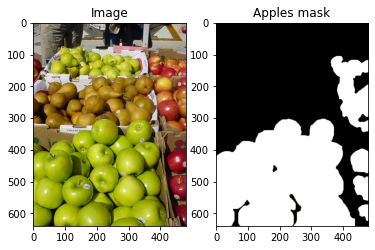

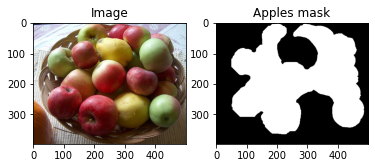

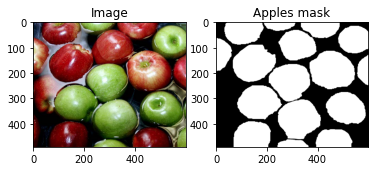

In [3]:
# Load images
imgs = load_images(sorted(glob.glob('./data/apples/train/*.jpg')))
apple_masks = load_images(sorted(glob.glob('./data/apples/train/*.png')))

# Plot a sample image and corresponding mask
for i in range(len(imgs)):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(imgs[i])
    ax1.set_title('Image')
    ax2.imshow(apple_masks[i])
    ax2.set_title('Apples mask')

In [4]:
# Check how many unique values in a mask
print(f'Min value: {apple_masks[0].min()}')
print(f'Max value: {apple_masks[0].max()}')
print(f'Number of unique values: {len(np.unique(apple_masks[0]))}')

Min value: 0.0
Max value: 1.0
Number of unique values: 196


We must make sure that the masks have binary values

In [5]:
# Convert  masks to have binary values and store only the first dimension
for i, mask in enumerate(apple_masks):
    apple_masks[i] = np.round(mask[:,:,0])

In [6]:
# Create apples and non apples data
apple_data = []
non_apple_data = []
for img, mask in zip(imgs, apple_masks):
    m, n, d = img.shape
    img_transformed = img.reshape(m*n, -1)
    mask = mask.reshape(-1)
    for idx, val in enumerate(mask):
        if val:
            apple_data.append(img_transformed[idx, :])
        else:
            non_apple_data.append(img_transformed[idx, :])

# Normalize and cast to double to avoid numerical errors
apple_data = np.double(np.array(apple_data) / 255.0)
non_apple_data = np.double(np.array(non_apple_data) / 255.0)

# Check shapes
print(f'Apple data shape: {apple_data.shape}')
print(f'Non apple data shape: {non_apple_data.shape}')

Apple data shape: (425702, 3)
Non apple data shape: (374598, 3)


# Train models

Log Likelihood After Iter 0 : 285398.217

Log Likelihood After Iter 1 : 293998.713

Log Likelihood After Iter 2 : 320009.672

Log Likelihood After Iter 3 : 362352.235

Log Likelihood After Iter 4 : 407878.266

Log Likelihood After Iter 5 : 443880.884

Log Likelihood After Iter 6 : 460003.593

Log Likelihood After Iter 7 : 463757.792

Log Likelihood After Iter 8 : 465305.108

Log Likelihood After Iter 9 : 466589.415

Log Likelihood After Iter 10 : 468063.432

Log Likelihood After Iter 11 : 470479.142

Log Likelihood After Iter 12 : 475605.150

Log Likelihood After Iter 13 : 485999.375

Log Likelihood After Iter 14 : 502144.598

Log Likelihood After Iter 15 : 519860.664

Log Likelihood After Iter 16 : 533589.347



Text(0, 0.5, 'log-likelihood')

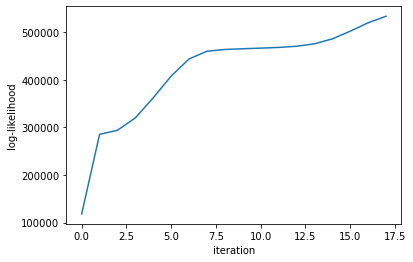

In [7]:
# Train MoG for apples
apple_model = GaussianMixture(n_components=3)
apple_model.fit(apple_data, max_iter=16)
# Plot log-likelihood
loglike_vec = apple_model.history['train_loglike']
plt.plot(loglike_vec)
plt.xlabel('iteration')
plt.ylabel('log-likelihood')

Log Likelihood After Iter 0 : 414483.898

Log Likelihood After Iter 1 : 434632.600

Log Likelihood After Iter 2 : 482335.450

Log Likelihood After Iter 3 : 538757.869

Log Likelihood After Iter 4 : 579237.972

Log Likelihood After Iter 5 : 606591.946

Log Likelihood After Iter 6 : 625463.939

Log Likelihood After Iter 7 : 639295.871

Log Likelihood After Iter 8 : 650581.691

Log Likelihood After Iter 9 : 657075.402

Log Likelihood After Iter 10 : 660537.437

Log Likelihood After Iter 11 : 662598.013

Log Likelihood After Iter 12 : 664094.118

Log Likelihood After Iter 13 : 665453.663

Log Likelihood After Iter 14 : 666922.236

Log Likelihood After Iter 15 : 668654.975

Log Likelihood After Iter 16 : 670748.919



Text(0, 0.5, 'log-likelihood')

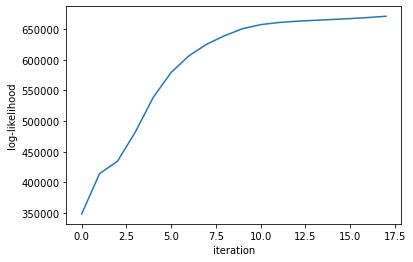

In [8]:
# Train MoG for non apples
non_apple_model = GaussianMixture(n_components=3)
non_apple_model.fit(non_apple_data, max_iter=16)
# Plot log-likelihood
loglike_vec = non_apple_model.history['train_loglike']
plt.plot(loglike_vec)
plt.xlabel('iteration')
plt.ylabel('log-likelihood')

The log-likelihoods are positive because we use PDF. Most importantly the likelihoods are increasing.

# Get Test Posterior Images

In [9]:
def calculate_posterior_img(img, model, non_model, prior=0.5, non_prior=0.5):
    # Reshape and normalize
    data = img.reshape(-1, img.shape[-1])
    data = np.double(data / 255.0)
    # Get likelihoods
    like = model.predict_proba(data)
    non_like = non_model.predict_proba(data)
    # Calculate posterior using Bayes rule and reshape into img
    posterior = (like * prior) / (like*prior + non_like*non_prior)
    posterior = posterior.reshape(img.shape[:-1])
    return posterior

In [10]:
# Upload test dataset
test_imgs = load_images(sorted(glob.glob('./data/apples/test/*.jpg')))
test_mask = load_images(glob.glob('./data/apples/test/*.png'))[0]
test_mask = np.round(test_mask[:,:,0])
mask_img_idx = 1

In [11]:
# Get posterior probabilities of test dataset
test_posterior_imgs = []
for i, img in enumerate(test_imgs):
    posterior_img = calculate_posterior_img(img, apple_model, non_apple_model)
    test_posterior_imgs.append(posterior_img)

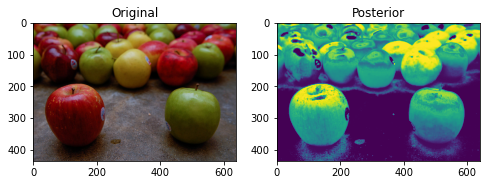

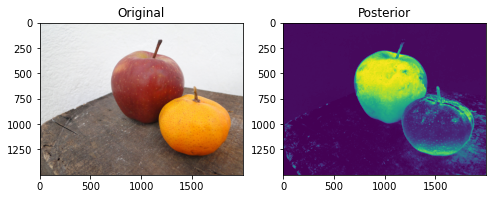

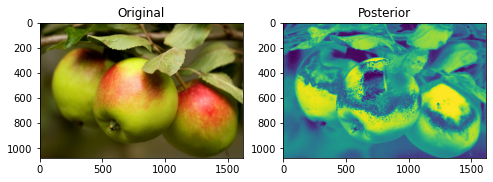

In [12]:
# Plot results
for test_img, posterior_img in zip(test_imgs, test_posterior_imgs):
    f, axes = plt.subplots(1, 2, figsize=(8, 6))
    axes = axes.flat
    
    axes[0].imshow(test_img)
    axes[0].set_title('Original')

    axes[1].imshow(posterior_img)
    axes[1].set_title('Posterior')

# Evaluate results

In [13]:
def predict(probs, thresh):
    preds = np.floor(probs + 1.0 - thresh)
    return preds

def confusion(y, y_pred):
    # Calculate tp, fp, tn, fn
    tp, fp, tn, fn = 0, 0, 0, 0
    for i in range(len(y_pred)): 
        if y[i]==y_pred[i]==1:
           tp += 1
        if y_pred[i]==1 and y[i]!=y_pred[i]:
           fp += 1
        if y[i]==y_pred[i]==0:
           tn += 1
        if y_pred[i]==0 and y[i]!=y_pred[i]:
           fn += 1
    return tp, fp, tn, fn

def roc_curve(y, probs, n_thresh=41):
    tpr = np.zeros(n_thresh)
    fpr = np.zeros(n_thresh)
    thresholds = np.linspace(0, 1, n_thresh)
    for i, thresh in enumerate(thresholds):
        y_pred = predict(probs, thresh)
        tp, fp, tn, fn = confusion(y, y_pred)
        tpr[i] = tp / (tp+fn)
        fpr[i] = fp / (fp+tn)
    return tpr, fpr, thresholds

def auc_from_roc(tpr, fpr):
    # Get auc using trapezoidal integration
    auc = 0
    for i in range(len(tpr)-1):
        auc += (tpr[i] + tpr[i+1]) * (fpr[i] - fpr[i+1]) / 2
    return auc

def plot_roc_curve(y, probs, n_thresh=41):
    tpr, fpr, thresholds = roc_curve(y, probs, n_thresh)
    n = len(tpr)
    plt.plot(np.linspace(0, 1, n), np.linspace(0, 1, n), ls='--', label='Random')
    plt.plot(fpr, tpr, marker='.', label='ROC')
    plt.title(f'AUC = {np.round(auc_from_roc(tpr, fpr), 3)}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
        
def get_confusion_table(y, probs):
    table = {
        'Threshold': [],
        'TP': [],
        'FP': [],
        'TN': [],
        'FN': []
    }
    # Calculate tp, fp, tn, fn for different thresholds 
    for thresh in np.arange(0.1, 1.0, 0.1):
        preds = predict(probs, thresh)
        tp, fp, tn, fn = confusion(y, preds)
        table['Threshold'].append(thresh)
        table['TP'].append(tp)
        table['FP'].append(fp)
        table['TN'].append(tn)
        table['FN'].append(fn)
    # Normalize tp, fp, tn, fn for better interpretation
    table_df = pd.DataFrame(table)
    table_df = table_df.set_index(['Threshold'])
    table_df = table_df.div(table_df.sum(axis=1), axis=0)
    # Add Accuracy, Sensitivity, Specificity, Precision, F1 Score
    table_df['Acc'] = table_df['TP'] + table_df['TN']
    table_df['Sensitivity'] = table_df['TP'] / (table_df['TP'] + table_df['FN'])
    table_df['Specificity'] = table_df['TN'] / (table_df['TN'] + table_df['FP'])
    table_df['Precision'] = table_df['TP'] / (table_df['TP'] + table_df['FP'])
    table_df['F1'] = (2 * table_df['Precision'] * table_df['Sensitivity'] 
                     / (table_df['Precision'] + table_df['Sensitivity']))
    return table_df

### Analyze on the test image with mask

Text(0.5, 1.0, 'Posterior')

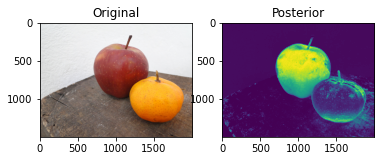

In [14]:
# Plot analyzed image
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(test_imgs[mask_img_idx])
ax1.set_title('Original')

ax2.imshow(test_posterior_imgs[mask_img_idx])
ax2.set_title('Posterior')

In [15]:
probs = test_posterior_imgs[mask_img_idx].reshape(-1)
y = test_mask.reshape(-1)

# Show confusion table
table_df = get_confusion_table(y, probs)
np.round(table_df, 3)

,TP,FP,TN,FN,Acc,Sensitivity,Specificity,Precision,F1
Threshold,,,,,,,,,
0.1,0.127,0.135,0.737,0.001,0.864,0.990,0.845,0.484,0.650
0.2,0.126,0.071,0.801,0.002,0.927,0.985,0.918,0.638,0.774
0.3,0.125,0.046,0.826,0.003,0.951,0.978,0.947,0.730,0.836
0.4,0.123,0.030,0.842,0.005,0.965,0.963,0.965,0.803,0.876
0.5,0.118,0.020,0.852,0.010,0.970,0.925,0.977,0.853,0.887
0.6,0.104,0.014,0.858,0.024,0.962,0.815,0.984,0.883,0.847
0.7,0.087,0.008,0.864,0.041,0.951,0.677,0.991,0.917,0.779
0.8,0.070,0.001,0.871,0.058,0.940,0.544,0.999,0.983,0.700
0.9,0.044,0.000,0.872,0.084,0.916,0.343,1.000,0.999,0.510


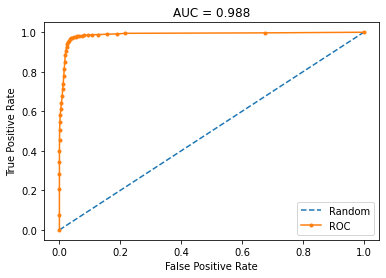

In [16]:
# Calculate and plot ROC curve
plot_roc_curve(y, probs)